# Analyse Rotation Spectra - Colorlines Overview


## Load Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path
from scipy.stats import median_absolute_deviation as mad

import os
import pickle
import matplotlib.pyplot as plt

In [2]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/kilauea-data/"
elif os.uname().nodename == "kilauea":
    root_path = "/import/kilauea-data/"

In [3]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [4]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [5]:
def __get_minimum_psd(psds, f_tmp):
    
    from numpy import median
    
    f_before = f_tmp[0]
    f_tmp[0] = 1e-9
    
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = (psds[0]/f_tmp).sum()
#             lowest_value = median(psds[0]/f_tmp)
            idx = 0

        value = (psd/f_tmp).sum() 
#         value = median(psd/f_tmp)
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    f_tmp[0] = f_before      
    
    return psds[idx]

In [6]:
# def __write_to_csv(data, text, config):
    
#     import csv
    
#     opath = config['outpath']
#     oname = config['outname']+"_"+text+"_psd.csv"
    
#     # open the file in the write mode
#     with open(opath+oname, 'w') as file:

#         writer = csv.writer(file)
#         for row in data:
#             writer.writerow(row)
            
#     if Path(opath+oname).exists():
#         print(f"created: {opath}{oname}")

In [7]:
def __load_psds(file, config):

    ## get data to dataframe and transpose and reindex
    df = read_csv(file, index_col=False)
    df = df.transpose()
    df.reset_index(inplace=True)
    # df.dtypes
    # df.mean()

    ## set column names
    try:
        columns = pickle.load(open(f"{config['inpath']}{config['inname']}_columns.pick", 'rb'))
        df.columns = [column.replace("-","") for column in columns]
    except:
        columns = arange(0,df.shape[1]).astype(str)
        df.columns = columns
        print(" -> Failed to assign column names! Assigned numbers instead!")

    ## check for column dublicates
    if len(df.columns.unique()) != len(df.columns):
        print(f" -> removing {len(df.columns)-len(df.columns.unique())} column dublicate(s)!")
        df = df.loc[:,~df.columns.duplicated()]

    count=0
    dates_expected = date_range(config['date1'].date, config['date2'].date, periods=int((config['date2']-config['date1'])/86400)+1)
    for dex in dates_expected:
        dex=str(dex.isoformat()[:10]).replace("-","")
        if not dex in df.columns:
            count+=1
    print(f" -> missing {count} days")
        
    print(f" -> total of {df.shape[0]} psds")
        
#     ## convert to list
#     psds = []
#     for col in array(df.columns):
        
#         ## turn non-float series to float objects
#         df[col] = pd.to_numeric(df[col], errors = 'coerce')

#         ## add to psds list
#         psds.append(array(df[col]))
        
    return df

In [8]:
def __get_array_from_dataframe(df):
    
    from pandas import to_numeric
    
    ## convert to list
    psds = []
    for col in array(df.columns):
        
        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [9]:
# def __remove_noisy_psds(df, threshold_mean=1e-13):

#     from numpy import delete
    
#     l1 = len(df.columns)
#     for col in df.columns:
# #         print(col, type(col))
#         if df[col].astype(float).mean() > threshold_mean:
#             df = df.drop(columns=col)
#     l2 = len(df.columns)
#     print(f" -> removed {l1-l2} columns due to mean thresholds!")
#     print(f" -> {l2} psds remain")
    
#     return df

In [10]:
os.listdir( f"{root_path}ROMY/RotationSpectra/data/run_2019_RGRF-Z_3600_GRF" )

['run_2019_RGRF-Z_3600_GRF20190128_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190619_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190626_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20191012_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20191117_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190808_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190225_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190924_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20191005_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190323_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190512_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190614_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190723_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190212_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20191221_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190301_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190213_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190819_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20191001_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190820_hourly.pkl',
 'run_2019_RGRF-Z_3600_GRF20190422_hourl

## Configurations

In [11]:
inname = "run_2019_RGRF-Z_3600_GRF"
inpath = f"{root_path}ROMY/RotationSpectra/data/{inname}/"


# config = pickle.load(open(inpath+inname+"_config.pick", 'rb'))
config = pickle.load(open(inpath+inname+"_config.pkl", 'rb'))

config['save'] = True

config['inname'] = inname
config['inpath'] = inpath

config['rlnm_model_path'] = f"{root_path}LNM/data/MODELS/"

config['frequency_limits'] = [1/200, 1]

## load frequencies
ff_Z = pickle.load(open(f"{config['inpath'].replace('Z','Z')}{config['inname'].replace('Z','Z')}_frequency_axis.pkl", 'rb'))
ff_N = pickle.load(open(f"{config['inpath'].replace('Z','N')}{config['inname'].replace('Z','N')}_frequency_axis.pkl", 'rb'))
ff_E = pickle.load(open(f"{config['inpath'].replace('Z','E')}{config['inname'].replace('Z','E')}_frequency_axis.pkl", 'rb'))

## Processing 

In [12]:
def __load_data(path, name):
    file = f"{path}{name}_daily_medians.pkl"
    print(f" -> loading {file} ...")
    
    psds_all = read_pickle(file)
    
    return psds_all

In [13]:
ADR_Z_df = __load_data(config['inpath'].replace("Z","Z"), config['inname'].replace("Z","Z"))

ADR_N_df = __load_data(config['inpath'].replace("Z","N"), config['inname'].replace("Z","N"))

ADR_E_df = __load_data(config['inpath'].replace("Z","E"), config['inname'].replace("Z","E"))

 -> loading /import/kilauea-data/ROMY/RotationSpectra/data/run_2019_RGRF-Z_3600_GRF/run_2019_RGRF-Z_3600_GRF_daily_medians.pkl ...
 -> loading /import/kilauea-data/ROMY/RotationSpectra/data/run_2019_RGRF-N_3600_GRF/run_2019_RGRF-N_3600_GRF_daily_medians.pkl ...
 -> loading /import/kilauea-data/ROMY/RotationSpectra/data/run_2019_RGRF-E_3600_GRF/run_2019_RGRF-E_3600_GRF_daily_medians.pkl ...


In [14]:
def __cut_frequencies_dataframe(df_psd, fmin, fmax, freqs=None):
    ind = []
    if freqs is None:
        frequencies = df_psd['frequencies']
    else:
        frequencies = freqs
    
    for i,f in enumerate(frequencies):    
        if f >= fmin and f <= fmax:
            ind.append(i)
    df = df_psd.iloc[ind[0]:ind[-1],:]
    df.reset_index(drop=True, inplace=True)
    
    if freqs is None:
        ff_new = None
    else:
        ff_new = freqs[ind[0]:ind[-1]]
        
    print(df.shape, len(ff_new))
    return df, ff_new

In [15]:
ADR_Z_df, ff_Z = __cut_frequencies_dataframe(ADR_Z_df, 1/30, 1, freqs=ff_Z)
ADR_N_df, ff_N = __cut_frequencies_dataframe(ADR_N_df, 1/30, 1, freqs=ff_N)
ADR_E_df, ff_E = __cut_frequencies_dataframe(ADR_E_df, 1/30, 1, freqs=ff_E)

(1237, 365) 1237
(1237, 365) 1237
(1237, 365) 1237


In [16]:
ADR_Z = __get_array_from_dataframe(ADR_Z_df)
ADR_N = __get_array_from_dataframe(ADR_N_df)
ADR_E = __get_array_from_dataframe(ADR_E_df)

In [17]:
# if "RLAS-Z" in config['inname'].split("_"):
#     psds_all = __remove_noisy_psds(psds_all, threshold_mean=1e-21)
# elif "ROMY-Z" in config['inname'].split("_"):
#     psds_all = __remove_noisy_psds(psds_all, threshold_mean=1e-19)

## Plotting

In [18]:
def __makeplot_colorlines(config, ff, psds, dates):

#     from numpy import isnan, median, mean, std, array
        
    psds_median  = __get_median_psd(array(psds))
    psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)
    
        
    ##____________________________
    
    fig, ax = plt.subplots(1,1, figsize=(15,10), sharey=False, sharex=True)

    font = 12

    N = psds.shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))

    for n, psd in enumerate(psds):
        ax.loglog(ff, psd, color=colors[n], alpha=0.7)


    ## add scatter for colorbar object only
    for n, psd in enumerate(psds):
        p2 = ax.scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)

    ## plot statistics
    ax.loglog(ff, psds_median, 'black', zorder=3, alpha=0.9)
#     ax.loglog(ff, psds_minimal, 'black', zorder=2, alpha=1.0)
#     ax.loglog(ff, psds_minimum, 'k', zorder=2, alpha=0.8)
    
    
    ## theoretical rlnm
    rlnm = read_csv(config['rlnm_model_path']+"rlnm_theory.csv")
    ax.loglog(rlnm['period'], rlnm['rlnm_psd_median'], color="grey", zorder=2, lw=2, label="RLNM")
    

#     ax.set_title("Minimal PSD", fontsize=font)
#     ax.set_title("Minimum PSD", fontsize=font)


#     ax.set_xlabel("Frequency (Hz)", fontsize=font)
    ax.set_xlabel("Period (s)", fontsize=font)

    ax.set_ylabel(r"PSD (rad$^2$/s$^2$/$Hz)$", fontsize=font)
    
    ax.grid(True, which="both", ls="-", alpha=0.7)
    
    ax.set_xlim(1,200)
    ax.set_ylim(1e-26,1e-20)
    
    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='horizontal', ax=ax, aspect=50)

    ## redefine ticks of colorbar
    new_ticks=[]
    for t in cbar.get_ticks(): 
        new_ticks.append(dates.astype(str)[int(t)])
    cbar.ax.set_xticklabels(new_ticks)


    plt.show();
    
    return fig

In [19]:
# fig, out = __makeplot_colorlines(config, 1/ff, GRF_Z, GRF_Z_df.columns)
# fig, out = __makeplot_colorlines(config, 1/ff, GRF_N, GRF_N_df.columns)
# fig, out = __makeplot_colorlines(config, 1/ff, GRF_E, GRF_E_df.columns)

In [24]:
def __makeplot_colorlines_overview(ff, psds, dates=None):
    
    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad
    
#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)

    ## theoretical rlnm
    rlnm = read_csv(config['rlnm_model_path']+"rlnm_theory.csv")

    pp = zeros(len(ff))
    pp[:-1] = 1/ff[1:]
        
    ##____________________________
    
    NN = 3
    
    fig, axes = plt.subplots(NN,1, figsize=(10,10), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)
    
    font = 14

    N = psds[0].shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))

    for j in range(NN):
        for n, psd in enumerate(tqdm(psds[j])):
            axes[j].loglog(pp, psd, color=colors[n], alpha=0.7)
            p2 = axes[j].scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)
 
        axes[j].loglog(pp, __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.9, label="Median")
        axes[j].loglog(rlnm['period'], rlnm['rlnm_psd_median'], color="black", zorder=2, ls="--", lw=2, label="RLNM")
        axes[j].set_ylabel(r"PSD (rad$^2$/s$^2$/$Hz)$", fontsize=font)
        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].set_xlim(1,200)
        axes[j].set_ylim(1e-26, 1e-17)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)
        
#     ax.set_title(f"{config['inname'].split('_')[2]} {config['inname'].split('_')[1]} ({len(psds)})", fontsize=font)

    axes[NN-1].set_xlabel("Period (s)", fontsize=font)

    
    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50)
    
    ## redefine ticks of colorbar
    if dates is not None:
        new_ticks = []
        for t in cbar.get_ticks(): 
            new_ticks.append(dates.astype(str)[int(t)])
        cbar.ax.set_yticklabels(new_ticks)


    plt.show();    
    return fig

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

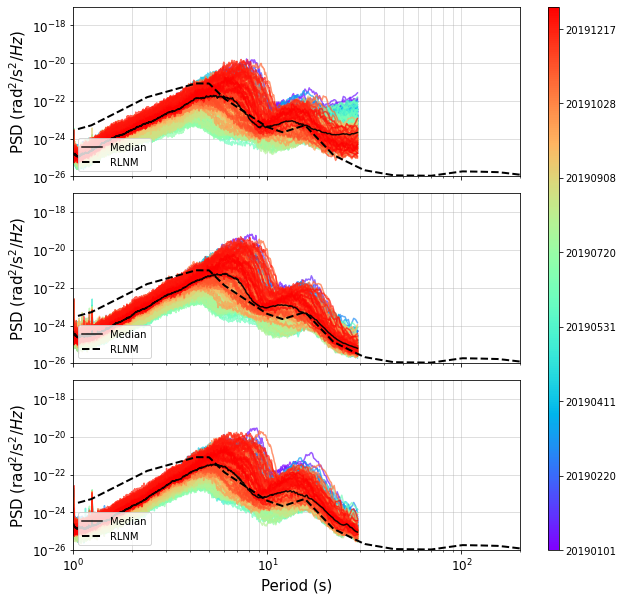

In [25]:
fig = __makeplot_colorlines_overview(ff_Z, [ADR_Z, ADR_N, ADR_E], dates=ADR_Z_df.columns)

## Calculate and Plot Density

In [ ]:
# output = __calculate_density(psds, bins=100, density=True)

In [ ]:
# def __makeplot_PPSD(ff, output, config, mode=None):

#     from matplotlib import colors
#     from numpy import ones, convolve, array, log10, roll, sqrt

#     bins, bins_medians, bins_maximas, dist = output['bin_mids'], output['bins_medians'], output['bins_maximas'], output['dist']
    
#     if mode is "DB":
#         y_axis = 10*log10(bins)
#     elif mode is "PSD":
#         y_axis = bins
#     elif mode is "ASD":
#         y_axis = sqrt(bins)
        
#     x_axis = ff

#     ## plotting
#     fig, ax = plt.subplots(1,1,figsize=(13,6))

#     font=14

#     cmap = plt.cm.get_cmap('magma_r')
# #     cmap = plt.cm.get_cmap('gray_r')
#     cmap.set_under(color='white')

#     im = plt.pcolor(x_axis, y_axis, dist.T, 
#                     cmap=cmap,
#                     vmin=1e-12, 
#                     alpha=0.99,
#                    )

#     ## add Frequency Axis
#     g = lambda x: 1/x
#     ax2 = ax.secondary_xaxis("top", functions=(g,g))
#     ax2.set_xlabel("Frequency in Hz", fontsize=font, labelpad=5)
#     ax2.set_xticklabels(1/ff, fontsize=11)    
    
    
#     if mode is "DB":
#         plt.plot(x_axis, 10*log10(bins_medians), color='black', alpha=0.5, label="RNLM")
#         plt.ylim(-200, -80)

#     elif mode is "PSD":
#         plt.plot(x_axis, bins_medians, color='black', alpha=0.5, label="RNLM")
#         plt.yscale('log')
#         plt.ylim(10**-20, 10**-13)
  
#     elif mode is "ASD":  
#         plt.plot(x_axis, sqrt(bins_medians), color='black', alpha=0.5, label="RNLM")
#         plt.yscale('log')
#         plt.ylim(10**-10, 2*10**-7)

    
# #     plt.fill_betweenx(range(-270, -140), x1=0, x2=2.5, color="grey", alpha=0.4)
# #     plt.fill_betweenx(range(-270, -140), x1=200, x2=max(ff), color="grey", alpha=0.4)

#     ## modify x-axis
#     plt.xscale('log')
#     plt.xlim([min(x_axis), max(x_axis)])
# #     plt.xlim(1, 300)
    
#     ## add colorbar
#     caxes = fig.add_axes()
#     cb = plt.colorbar(im, cax=caxes, alpha=1.0)
    
#     if output['set_density']:
#         cb.set_label("Propability Density", fontsize=font)
#     else:
#         cb.set_label("Counts", fontsize=font)
#         cb.set_label("Propability Density", fontsize=font)
    
#     if mode is "DB":
# #         plt.ylabel(r"PPSD in dB (rel. to 1 m$^4$/s$^2$/$Hz$)", fontsize=font)
#         plt.ylabel(r"PPSD in dB (rel. to 1 rad$^2$/s$^2$/$Hz$)", fontsize=font)
#     elif mode is "PSD":
# #         plt.ylabel(r"PPSD in m$^4$/s$^2$/$Hz$", fontsize=font)
#         plt.ylabel(r"PPSD in $\frac{rad^2}{s^2 Hz}$", fontsize=font)
#     elif mode is "ASD":
#         plt.ylabel(r"PASD in $\frac{rad}{s \sqrt{Hz}}$", fontsize=font)
        
#     plt.grid(axis="both", which="both", ls="--", zorder=0)
#     plt.legend()
    
#     plt.xlabel("Period in seconds", fontsize=font)

#     plt.tick_params(axis='both', labelsize=font-2)

#     plt.show();
#     return fig

In [ ]:
# fig = __makeplot_PPSD(ff, output, config, mode="ASD")